In [3]:
import PyPDF2
import pandas as pd
import re
import numpy as np
import os
import fitz
from PIL import Image
import io
from functools import partial
import scipy
import skimage
from pyproj import Geod
import cv2 as cv
from scipy import ndimage as ndi
import copy
from numba import njit

%matplotlib inline

base_dir = '/home/student.unimelb.edu.au/shorte1/Documents/ACF_consulting'

In [4]:
table = pd.read_csv(base_dir + '/example_table.csv', dtype=str, sep='\t')
table['Threatened Species'] = 'None mentioned'
table['Map'] = False
species = pd.read_csv('threatened_species_202010.csv')

Extract "Threatened Species" and "Map?" column.

In [3]:
example_folders = [x[0].replace('/','') + '_' + x[1].replace('/','') for x in table[['Reference Number', 'Date of notice']].values]

In [4]:
# Check for scientific names 
# Loop through pdf files. Convert pdf to text. Search for scientific names.
folders = os.listdir("./files")

In [5]:
folders_revised = []
for folder in folders:
    for example_folder in example_folders:
        if example_folder in folder:
            folders_revised.append(folder)

In [6]:
folders_revised = list(set(folders_revised))
len(folders_revised)

93

In [7]:
folders=folders_revised

In [ ]:
# Loop through folders
for folder in folders_revised:
    print(folder)
    try:
        fn = folder.split('_')[0] + '_' + folder.split('_')[1] + '_combined.pdf'
        pdf_file_obj = open(base_dir + '/files/' + folder + '/' + fn, 'rb')
        pdf_reader = PyPDF2.PdfFileReader(pdf_file_obj)
    except:
        try:
            fn = folder + '_combined.pdf'
            pdf_file_obj = open(base_dir + '/files/' + folder + '/' + fn, 'rb')
            pdf_reader = PyPDF2.PdfFileReader(pdf_file_obj)
        except:
            continue

    try:
        pages = [
            pdf_reader.getPage(i).extractText().replace('\n', '') 
            for i in range(pdf_reader.numPages)
        ]
    except:
        continue
    text = ''.join(pages)
    
    text_lower = text.lower()
    sci_name = species['Scientific Name'].apply(lambda x: x.lower()).values
    comm_name = species['Common Name'].loc[
        np.logical_and(
            species['Common Name'] != 'a shrub', species['Common Name'] != '-'
        )
    ].apply(lambda x: x.lower()).values

    [sci_name_exist, comm_name_exist] = [
        [
            species['Common Name'].values[i] + ', ' 
            + species['Scientific Name'].values[i] + ' (' 
            +  species['Threatened status'].values[i] + ')' 
            for i in range(len(name)) if name[i] in text.lower()
        ]
        for name in [sci_name, comm_name]
    ]
    
    if 'coordinates' in text.lower() or 'latitude' in text.lower() or 'longitude' in text.lower() or ' map ' in text.lower():
        coordinates_mentioned = True
    else:
        coordinates_mentioned = False

    species_mentioned = sorted(
        list(set(sci_name_exist).union(set(comm_name_exist)))
    )
    species_mentioned = ', '.join(species_mentioned)
    
#     Extract text coordinates
#     text = re.sub('([-]?[0-9]{2}:[0-9]{2}:)([0-9]{1}).([0-9]{1})([0-9]{2})', '\g<1>\g<2>\g<3>.\g<4>', text)
#     text = re.sub('([-]?[0-9]{2}:[0-9]{2}:[0-9]{2}.[0-9]{2})([N,S]{1})', '\g<1> \g<2>', text)
#     points_lat = re.findall('[-]?[0-9]{2}:[0-9]{2}:[0-9]{2}.[0-9]{2} [N,S]{1}', text)
#     points_lon = re.findall('[-]?[0-9]{2,3}:[0-9]{2}:[0-9]{2}.[0-9]{2} [E,W]{1}', text)

    id_nums = folder.split('_')
    date = id_nums[1][:2] + '/' + id_nums[1][2:4] + '/' + id_nums[1][4:]
    ref_num = id_nums[0][:4] + '/' + id_nums[0][4:]
    table['Threatened Species'].loc[np.logical_and(
        table['Date of notice'] == date, table['Reference Number'] == ref_num
    )] = species_mentioned
    table['Map'].loc[np.logical_and(
        table['Date of notice'] == date, table['Reference Number'] == ref_num
    )] = coordinates_mentioned

In [13]:
table.to_csv('example_revised_table.csv', index=False, header=True)

In [20]:
coords = coords.reshape(int(len(coords)/2),2)
coords_new = np.zeros_like(coords)
coords_new[:,1] = coords[:,0]
coords_new[:,0] = coords[:,1]

In [3]:
pdf_file_obj = open('example_referral.pdf', 'rb')
pdf_reader = PyPDF2.PdfFileReader(pdf_file_obj)
pages = [pdf_reader.getPage(i).extractText().replace('\n', '') for i in range(pdf_reader.numPages)]

In [4]:
text = ''.join(pages)

Extract KML from text.

In [5]:
import fitz

In [6]:
text = re.sub('([-]?[0-9]{2}:[0-9]{2}:)([0-9]{1}).([0-9]{1})([0-9]{2})', '\g<1>\g<2>\g<3>.\g<4>', text)
text = re.sub('([-]?[0-9]{2}:[0-9]{2}:[0-9]{2}.[0-9]{2})([N,S]{1})', '\g<1> \g<2>', text)

In [7]:
text

"Referral of proposed action  Proposed action title: Yangibana Rare Earths Project  1 Summary of proposed action  1.1 Short description Hastings Technology Metals Limited (Hastings) proposes to develop the Yangibana Rare Earths Project (the Proposal), located approximately 270 km east-northeast of Carnarvon, in the Upper Gascoyne region of Western Australia (WA).  The Proposal will involve mining ferrocarbonatite-magnetite-rare earth bearing dykes.  Proposal activities include construction, mining, processing, decommissioning and rehabilitation of a rare earth mine, and associated infrastructure.  The Proposal is expected to have a mine life of approximately seven years. 1.2 Latitude and longitude Polygon enclosing entire referral area. Points are listed in a clockwise order.  Latitude Longitude Point degrees minutes seconds degrees minutes seconds 1 -23:54:44.60 S  116:05:52.08 E 2 -23:54:09.76 S  116:06:12.24 E 3 -23:52:05.05 S  116:07:43.68 E 4 -23:50:13.59 S  116:10:00.12 E 5 -23:4

In [8]:
points_lat = re.findall('[-]?[0-9]{2}:[0-9]{2}:[0-9]{2}.[0-9]{2} [N,S]{1}', text)
points_lon = re.findall('[-]?[0-9]{2,3}:[0-9]{2}:[0-9]{2}.[0-9]{2} [E,W]{1}', text)

In [9]:
def convert_to_decimal(old):
    direction = {'N':1, 'S':-1, 'E': 1, 'W':-1}
    new = old.replace(':',' ')
    new = new.split()
    new_dir = new.pop()
    return (abs(float(new[0]))+float(new[1])/60.0+float(new[2])/3600.0) * direction[new_dir]

In [10]:
points_lat = [convert_to_decimal(i) for i in points_lat]
points_lon = [convert_to_decimal(i) for i in points_lon]

In [11]:
len(points_lat)
# len(points_lon)

43

In [21]:
kml_coords = [(points_lon[i], points_lat[i]) for i in range(len(points_lat))]

In [22]:
kml_coords

[(116.09779999999999, -23.912388888888888),
 (116.1034, -23.90271111111111),
 (116.1288, -23.868069444444444),
 (116.1667, -23.837108333333333),
 (116.1847, -23.83203888888889),
 (116.2014, -23.83203888888889),
 (116.2429, -23.857950000000002),
 (116.2667, -23.87602777777778),
 (116.2847, -23.88202777777778),
 (116.3014, -23.88202777777778),
 (116.3167, -23.923008333333335),
 (116.3232, -23.94103888888889),
 (116.3231, -23.9528),
 (116.3059, -23.96666944444444),
 (116.29169999999999, -23.96666944444444),
 (116.2423, -24.002580555555557),
 (116.2818, -24.0853),
 (116.2837, -24.09245),
 (116.2835, -24.09570833333333),
 (116.2831, -24.097158333333333),
 (116.2824, -24.098488888888888),
 (116.2814, -24.099619444444443),
 (116.2799, -24.100580555555556),
 (116.27695, -24.1019),
 (116.27629999999999, -24.10068888888889),
 (116.2709, -24.07348888888889),
 (116.25835, -24.06573888888889),
 (116.22840000000001, -24.048269444444447),
 (116.2269, -24.047127777777778),
 (116.22585000000001, -24.04

In [25]:
import simplekml

In [41]:
trans_green_style = simplekml.Style()
trans_green_style.linestyle.width = 1.5
trans_green_style.polystyle.color = '7d00ff00'
trans_green_style.name = 'trans_green_style'

kml = simplekml.Kml()
kml.document.name = "Referral Name Text Extract"
pol1 = kml.newpolygon(name = "Referral Area", outerboundaryis=kml_coords)
pol1.style.linestyle.width = 1.5
pol1.style = trans_green_style

In [43]:
kml.save('simple_kml_test.kml')

In [18]:
direction = {'N':1, 'S':-1, 'E': 1, 'W':-1}
test = points_lat[0]

Extract from images.

In [3]:
file = '/home/student.unimelb.edu.au/shorte1/Documents/ACF_consulting/example_referral.pdf'
pdf_file = fitz.open(file)

In [4]:
pdf_file

Document('/home/student.unimelb.edu.au/shorte1/Documents/ACF_consulting/example_referral.pdf')

In [5]:
page = pdf_file[32]
image_list = page.getImageList()
image_list


import fitz
doc = fitz.open("file.pdf")
for i in range(len(doc)):
    for img in doc.getPageImageList(i):
        xref = img[0]
        pix = fitz.Pixmap(doc, xref)
        if pix.n < 5:       # this is GRAY or RGB
            pix.writePNG("p%s-%s.png" % (i, xref))
        else:               # CMYK: convert to RGB first
            pix1 = fitz.Pixmap(fitz.csRGB, pix)
            pix1.writePNG("p%s-%s.png" % (i, xref))
            pix1 = None
        pix = None

mupdf: cannot open file.pdf: No such file or directory


RuntimeError: cannot open file.pdf: No such file or directory

In [7]:
from operator import itemgetter

page = pdf_file[32]
blocks = page.getTextBlocks()
# sb = sorted(blocks, key=itemgetter(1, 0))
# fout = open('test.txt', "wb")
# for b in sb:
#     fout.write(b[4].encode("utf-8"))

# fout.close()
test = blocks[35]

In [6]:
for page_index in range(len(pdf_file)):
    # get the page itself
    page = pdf_file[page_index]
    image_list = page.getImageList()
    # printing number of images found in this page
    if image_list:
        # Zoom in to ensure pdf page is saved at good resolution
        zoom_x = 4.0  # horizontal zoom
        zomm_y = 4.0  # vertical zoom
        mat = fitz.Matrix(zoom_x, zomm_y)  # zoom factor 2 in each dimension
        pix = page.get_pixmap(matrix=mat)  # use 'mat' instead of the identity matrix
        pix.writePNG("page-%i.png" % page.number)  # store image as a PNG

In [7]:
from skimage.io import imread
from scipy import ndimage as ndi
from skimage import feature
from skimage.color import rgb2gray 
from skimage.color.adapt_rgb import adapt_rgb, each_channel, hsv_value
import matplotlib.pyplot as plt
from skimage import filters

from skimage import data, segmentation, feature, future
from sklearn.ensemble import RandomForestClassifier
from functools import partial

Create training set to look for legend boxes in maps.

In [8]:
im1 = imread(base_dir + '/page-32.png')
im2 = imread(base_dir + '/page-33.png')
im3 = imread(base_dir + '/page-34.png')

page = pdf_file[32]
blocks = page.getTextBlocks()

In [9]:
def decodeBoundingBoxes(scores, geometry, scoreThresh):
    detections = []
    confidences = []

    ############ CHECK DIMENSIONS AND SHAPES OF geometry AND scores ############
    assert len(scores.shape) == 4, "Incorrect dimensions of scores"
    assert len(geometry.shape) == 4, "Incorrect dimensions of geometry"
    assert scores.shape[0] == 1, "Invalid dimensions of scores"
    assert geometry.shape[0] == 1, "Invalid dimensions of geometry"
    assert scores.shape[1] == 1, "Invalid dimensions of scores"
    assert geometry.shape[1] == 5, "Invalid dimensions of geometry"
    assert scores.shape[2] == geometry.shape[2], "Invalid dimensions of scores and geometry"
    assert scores.shape[3] == geometry.shape[3], "Invalid dimensions of scores and geometry"
    height = scores.shape[2]
    width = scores.shape[3]
    for y in range(0, height):

        # Extract data from scores
        scoresData = scores[0][0][y]
        x0_data = geometry[0][0][y]
        x1_data = geometry[0][1][y]
        x2_data = geometry[0][2][y]
        x3_data = geometry[0][3][y]
        anglesData = geometry[0][4][y]
        for x in range(0, width):
            score = scoresData[x]

            # If score is lower than threshold score, move to next x
            if (score < scoreThresh):
                continue

            # Calculate offset
            offsetX = x * 4.0
            offsetY = y * 4.0
            angle = anglesData[x]

            # Calculate cos and sin of angle
            cosA = math.cos(angle)
            sinA = math.sin(angle)
            h = x0_data[x] + x2_data[x]
            w = x1_data[x] + x3_data[x]

            # Calculate offset
            offset = ([offsetX + cosA * x1_data[x] + sinA * x2_data[x], offsetY - sinA * x1_data[x] + cosA * x2_data[x]])

            # Find points for rectangle
            p1 = (-sinA * h + offset[0], -cosA * h + offset[1])
            p3 = (-cosA * w + offset[0], sinA * w + offset[1])
            center = (0.5 * (p1[0] + p3[0]), 0.5 * (p1[1] + p3[1]))
            detections.append((center, (w, h), -1 * angle * 180.0 / math.pi))
            confidences.append(float(score))

    # Return detections and confidences
    return [detections, confidences]

In [13]:
ax.cla()
clear_output()

In [22]:
im1[:,:,2].mean()

230.6262403946849

<ipython-input-24-e9158d398f71>:40: DeprecationWarning: an integer is required (got type numpy.float32).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  cv.line(im1, p1, p2, (0, 255, 0), 3)


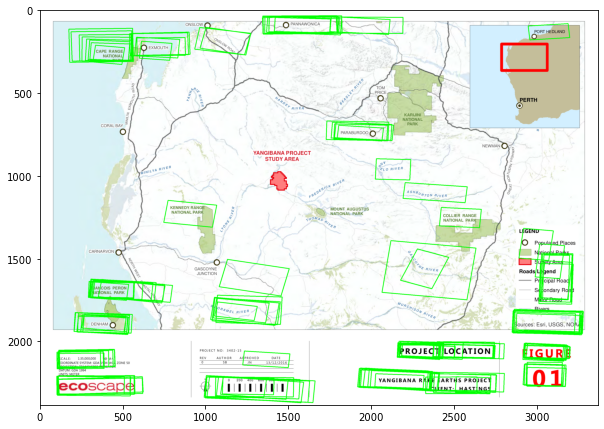

In [24]:
import math

from IPython.display import display, clear_output

net = cv.dnn.readNet("frozen_east_text_detection.pb")   #This is the model we get after extraction
inpWidth = inpHeight = 320  # A default dimension
# Preparing a blob to pass the image through the neural network
# Subtracting mean values used while training the model.
image_blob = cv.dnn.blobFromImage(im1, 1.0, (inpWidth, inpHeight), (123.68, 116.78, 103.94), True, False)

output_layer = []
output_layer.append("feature_fusion/Conv_7/Sigmoid")
output_layer.append("feature_fusion/concat_3")

net.setInput(image_blob)
output = net.forward(output_layer)
scores = output[0]
geometry = output[1]

confThreshold = 0.5
nmsThreshold = 0.3
[boxes, confidences] = decodeBoundingBoxes(scores, geometry, confThreshold)
indices = cv.dnn.NMSBoxesRotated(boxes, confidences, confThreshold, nmsThreshold)

height_ = im1.shape[0]
width_ = im1.shape[1]
rW = width_ / float(inpWidth)
rH = height_ / float(inpHeight)

for i in indices:
    # get 4 corners of the rotated rect
    vertices = cv.boxPoints(boxes[i[0]])
    # scale the bounding box coordinates based on the respective ratios
    for j in range(4):
        vertices[j][0] *= rW
        vertices[j][1] *= rH
    for j in range(4):
        p1 = (vertices[j][0], vertices[j][1])
        p2 = (vertices[(j + 1) % 4][0], vertices[(j + 1) % 4][1])
        cv.line(im1, p1, p2, (0, 255, 0), 3)
    
fig, ax = plt.subplots(figsize=(10,10))
ax.imshow(im1)

In [10]:
len(leg_blocks)

NameError: name 'leg_blocks' is not defined

In [66]:
zoom_factor = 4
leg_blocks = [
    np.round(np.array(x[0:4])*zoom_factor).astype(int) 
    for x in blocks 
    if zoom_factor*round(x[0]) >= rec[3]
    and zoom_factor*round(x[2]) <= rec[3]+rec[1]
    and zoom_factor*round(x[1]) >= rec[2]
    and zoom_factor*round(x[3]) <= rec[2]+rec[0]
]
leg_blocks = np.array(leg_blocks)

In [67]:
leg_blocks

array([[2894, 1316, 3235, 1425],
       [2987, 1441, 3196, 1484],
       [2987, 1497, 3161, 1541],
       [2894, 1554, 3116, 1598],
       [2987, 1609, 3196, 1653],
       [2987, 1667, 3226, 1711],
       [2987, 1724, 3153, 1767],
       [2987, 1780, 3077, 1824]])

In [64]:
box = leg_blocks[3]

In [20]:
# [col_min, row_min, col_max, row_max] = test[0:4]
box = [col_min, row_min, col_max, row_max] = [round(x*4) for x in test[0:4]]
box

NameError: name 'test' is not defined

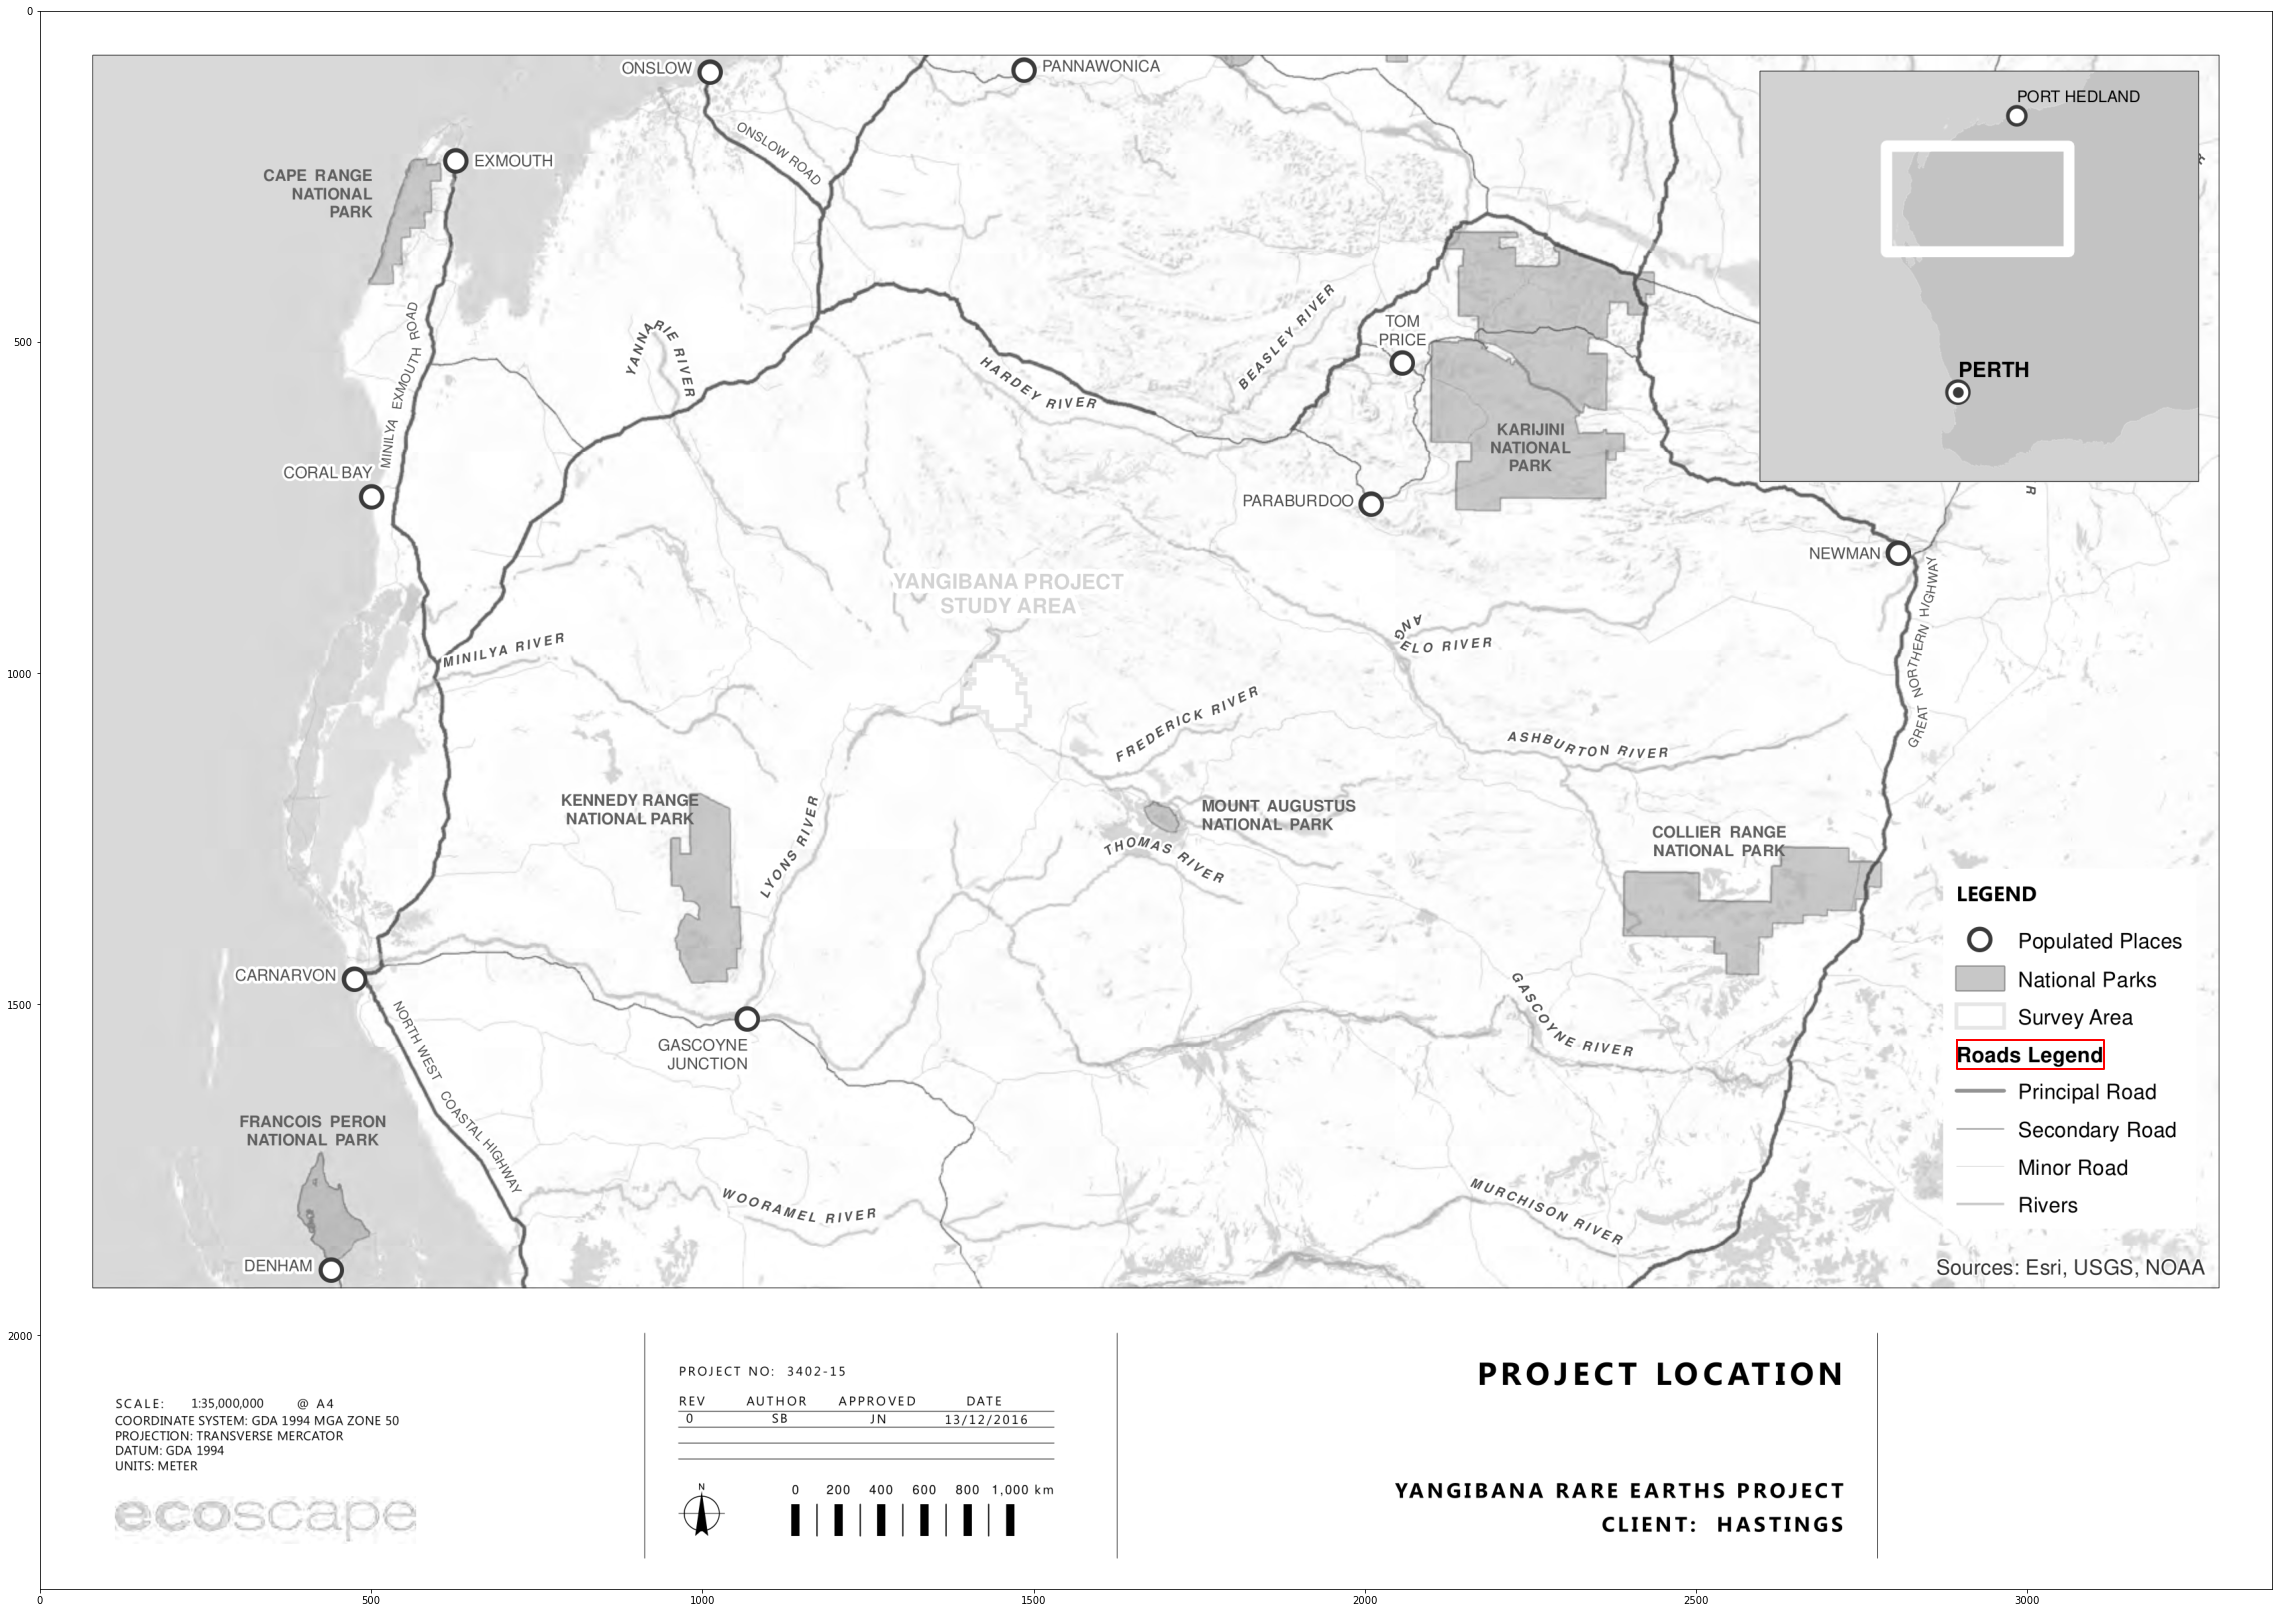

In [65]:
# display results
fig, ax1 = plt.subplots(
    figsize=(40, 40)
)
ax1.imshow(im1[:, :, 0], cmap='gray', vmin=0, vmax=255)
ax1.plot(
    [box[0], box[0], box[2], box[2], box[0]], 
    [box[1], box[3], box[3], box[1], box[1]], '-r', linewidth=2
)
# ax1.imshow(im[box_radius-box_radius:box_radius+box_radius, box_radius-box_radius:box_radius+box_radius, 2], cmap='gray', vmin=0, vmax=256)

In [11]:
from skimage import data, segmentation, feature, future
from sklearn.ensemble import RandomForestClassifier
from functools import partial

Strategy 1: Train to find legend

In [16]:
# Build an array of labels for training the segmentation.
# Here we use rectangles but visualization libraries such as plotly
# (and napari?) can be used to draw a mask on the image.
img = im
training_labels = np.zeros(img.shape[:2], dtype=np.uint8)

box_radius = 10

training_labels[1299:1835, 2876:3274] = 1
training_labels[0:1000, 0:1000] = 2
training_labels[-1000:-1, 1000:2000] = 2
training_labels[92:704, 2604:3254] = 2

sigma_min = 1
sigma_max = 4
features_func = partial(feature.multiscale_basic_features,
                        intensity=True, edges=False, texture=True,
                        sigma_min=sigma_min, sigma_max=sigma_max,
                        multichannel=True)
features = features_func(img)
clf = RandomForestClassifier(n_estimators=50, n_jobs=-1,
                             max_depth=10, max_samples=0.05)
clf = future.fit_segmenter(training_labels, features, clf)
result = future.predict_segmenter(features, clf)

fig, ax = plt.subplots(2, 1, sharex=True, sharey=True, figsize=(20, 40))
ax[0].imshow(segmentation.mark_boundaries(img, result, mode='thick'))
ax[0].contour(training_labels)
ax[0].set_title('Image, mask and segmentation boundaries')
ax[1].imshow(result, cmap='Pastel1')
ax[1].set_title('Segmentation')
fig.tight_layout()

NameError: name 'im' is not defined

Strategy 2: Use Sobel type transforms, then search for contours and look for squares containing other sqaures to find legend.

In [12]:
from collections import namedtuple
from operator import mul
from functools import reduce

Info = namedtuple('Info', 'start height')

def max_size(mat, value=0):
    """Find height, width of the largest rectangle containing all `value`'s.
    For each row solve "Largest Rectangle in a Histrogram" problem [1]:
    [1]: http://blog.csdn.net/arbuckle/archive/2006/05/06/710988.aspx
    """
    it = iter(mat)
    hist = [(el==value) for el in next(it, [])]
    max_size = max_rectangle_size(hist, 0)
    row_count = 1
    for row in it:
        hist = [(1+h) if el == value else 0 for h, el in zip(hist, row)]
        max_size = max(max_size, max_rectangle_size(hist, row_count), key=area)
        row_count += 1
    return max_size

def max_rectangle_size(histogram, row_count):
    """Find height, width of the largest rectangle that fits entirely under
    the histogram.
    """
    stack = []
    top = lambda: stack[-1]
    max_size = (0, 0, row_count, 0) # height, width of the largest rectangle
    pos = 0 # current position in the histogram
    for pos, height in enumerate(histogram):
        start = pos # position where rectangle starts
        while True:
            if not stack or height > top().height:
                stack.append(Info(start, height)) # push
            elif stack and height < top().height:
                max_size = max(
                    max_size, 
                    (
                        top().height, 
                        (pos - top().start), 
                        row_count-top().height,
                        top().start
                    ),
                    key=area
                )
                start, _ = stack.pop()
                continue
            break # height == top().height goes here

    pos += 1
    for start, height in stack:
        max_size = max(
            max_size, 
            (
                height, 
                (pos - start), 
                row_count-height,
                start
            ), 
            key=area
        )

    return max_size

def area(size):
    return reduce(mul, size[0:2])

In [109]:
# Convert image to grayscale to look for legend box
gray = cv.cvtColor(im1, cv.COLOR_BGR2GRAY)
binary = copy.deepcopy(gray)
# Assume legend has a near white background and a border
# Create a binary image that is >0 only when white or near white
grey_thresh = 255
binary[binary < grey_thresh]=0

# Search for contours in the binary image
contours, hierarchy = cv.findContours(
    binary, 
    cv.RETR_TREE, 
    cv.CHAIN_APPROX_SIMPLE
)

# Filter contours to those of a plausible size for legend box
pos_legend_inds = [
    i for i in range(len(contours))
    if cv.contourArea(contours[i]) >= 0.02*im2.shape[0]*im2.shape[1]
    and cv.contourArea(contours[i]) <= 0.5*im2.shape[0]*im2.shape[1]
]

if len(pos_legend_inds) > 5:
    print('Too many condidate contours for legend box!')

for ind in pos_legend_inds:
    legend = cv.drawContours(
        np.zeros_like(im1), contours, ind, (255,255,255), -1
    )
    legend = (cv.cvtColor(legend, cv.COLOR_BGR2GRAY) > 0).astype(int)
   
     # Find maximal inscribed rectangle and assume this is the legend box.
    rows, columns = np.where(legend > 0)
    obj_range = [
        np.amin(rows), np.amax(rows), np.amin(columns), np.amax(columns)
    ]
    rec = max_size(
        legend[obj_range[0]:obj_range[1], obj_range[2]:obj_range[3]],1
    )
    rec = list(rec)
    rec[2] += obj_range[0]
    rec[3] += obj_range[2]

#     fig, ax = plt.subplots(figsize=(20,20))
#     ax.imshow(binary)
#     ax.plot(
#         [rec[3], rec[3], rec[3]+rec[1], rec[3]+rec[1], rec[3]], 
#         [rec[2], rec[2]-rec[0], rec[2]-rec[0], rec[2],rec[2]] ,
#         '-r', linewidth=1
#     )

    # Loop through all child contours of legend contour, throw away ones that are too small
    child = hierarchy[0][ind][2]
    pos_region_inds = []
    leg_area = rec[0]*rec[1]

    while child != -1:
        
        if (
            cv.contourArea(contours[child]) > 0.001*leg_area
            and cv.contourArea(contours[child]) < 0.1*leg_area
        ):
            
            # Check if contour points in legend rectangle
            child_ar = contours[child].squeeze()
            child_rows = child_ar[:,1]
            child_columns = child_ar[:,0]
            
            row_cond = child_rows >= rec[2]
            row_cond *= child_rows <= rec[2] + rec[0]
            col_cond = child_columns >= rec[3]
            col_cond *= child_columns <= rec[3] + rec[1]

            in_rec = np.all(row_cond*col_cond)
            
            if in_rec:
            
                # Check if contours points in text boxes extracted from pdf
                col_cond = leg_blocks[:,0] <= child_ar[:,0,None]
                col_cond *= child_ar[:,0,None] <= leg_blocks[:,2]
                row_cond = leg_blocks[:,1] <= child_ar[:,1,None]
                row_cond *= child_ar[:,1,None] <= leg_blocks[:,3] 

#                 import pdb; pdb.set_trace()
                in_text = (row_cond*col_cond).all(0).any()

                if not in_text:
                    pos_region_inds.append(child)
        
        child = hierarchy[0][child][0]

In [110]:
pos_region_inds

[4639, 4650, 4668, 4688, 4746, 4767]

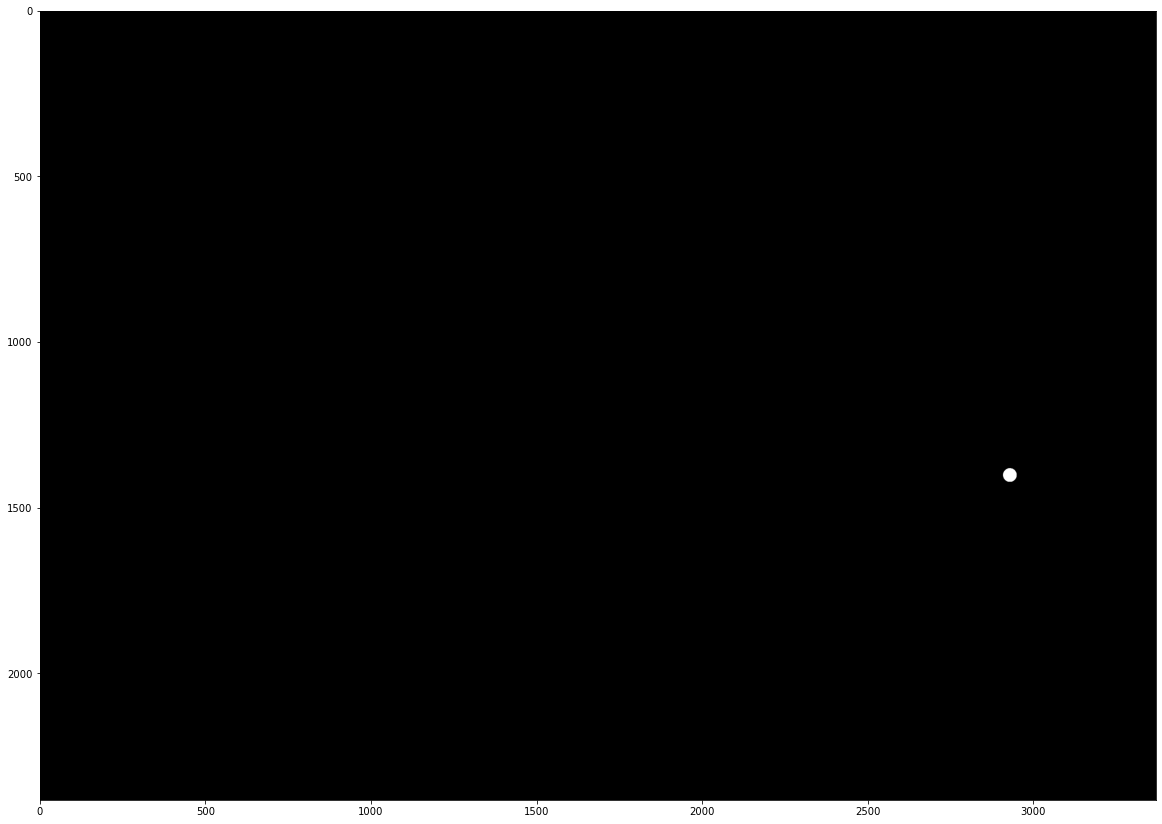

In [103]:
fig, ax = plt.subplots(figsize=(20,20))
contour_plot = cv.drawContours(
    np.zeros_like(im1), contours, 4792, (255,255,255), -1
)
ax.imshow(contour_plot)

In [390]:
child = hierarchy[0][ind][2]
child_rows = contours[child].squeeze()[:,1]
child_columns = contours[child].squeeze()[:,0]

row_cond = child_rows >= rec[2]
row_cond *= child_rows <= rec[2] + rec[0]
col_cond = child_columns >= rec[3]
col_cond = child_columns <= rec[3] + rec[1]

In [363]:
pos_region_inds

[4616,
 4619,
 4625,
 4632,
 4633,
 4635,
 4640,
 4643,
 4645,
 4647,
 4650,
 4653,
 4654,
 4656,
 4659,
 4661,
 4662,
 4664,
 4666,
 4667,
 4670,
 4672,
 4674,
 4676,
 4678,
 4680,
 4681,
 4682,
 4684,
 4686,
 4688,
 4695,
 4697,
 4702,
 4704,
 4705,
 4707,
 4709,
 4711,
 4712,
 4714,
 4716,
 4718,
 4719,
 4721,
 4727,
 4729,
 4732,
 4734,
 4735,
 4737,
 4739,
 4741,
 4743,
 4745,
 4748,
 4751,
 4754,
 4755,
 4759,
 4760,
 4762,
 4763,
 4766,
 4768,
 4770,
 4772,
 4774,
 4778,
 4780,
 4783,
 4785,
 4787,
 4789,
 4790,
 4791,
 4792,
 4793,
 4797,
 4799,
 4800,
 4806,
 4808,
 4810,
 4815]

In [8]:
print(pos_legend_inds)
print(hierarchy[0][pos_legend_inds[0]][2])
hierarchy[0][4622]

# Loop through all child contours of legend contour, throw away ones that are too small

child = hierarchy[0][pos_legend_inds[0]][2]
pos_region_inds = []
leg_area = cv.contourArea(contours[pos_legend_inds[0]])

while child != -1:
    if (
        cv.contourArea(contours[child]) > 0.005*leg_area
        and cv.contourArea(contours[child]) < 0.05*leg_area
    ):
        pos_region_inds.append(child)
    child = hierarchy[0][child][0] 
pos_region_inds

[4610]
4611


[4630, 4746, 4767, 4807]

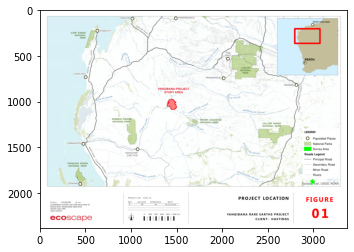

In [10]:
test = cv.drawContours(im1, contours, 4746, (0,255,0), -1)
plt.figure()
plt.imshow(test)

/home/student.unimelb.edu.au/shorte1/anaconda3/envs/acf/lib/python3.9/site-packages/skimage/io/_plugins/matplotlib_plugin.py:150: UserWarning: Low image data range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)


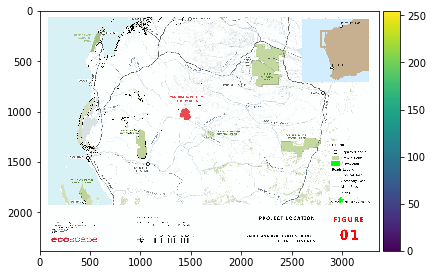

In [11]:
from skimage import data, io, segmentation, color
from skimage.future import graph
import numpy as np

def _weight_mean_color(graph, src, dst, n):
    """Callback to handle merging nodes by recomputing mean color.

    The method expects that the mean color of `dst` is already computed.

    Parameters
    ----------
    graph : RAG
        The graph under consideration.
    src, dst : int
        The vertices in `graph` to be merged.
    n : int
        A neighbor of `src` or `dst` or both.

    Returns
    -------
    data : dict
        A dictionary with the `"weight"` attribute set as the absolute
        difference of the mean color between node `dst` and `n`.
    """

    diff = graph.nodes[dst]['mean color'] - graph.nodes[n]['mean color']
    diff = np.linalg.norm(diff)
    return {'weight': diff}


def merge_mean_color(graph, src, dst):
    """Callback called before merging two nodes of a mean color distance graph.

    This method computes the mean color of `dst`.

    Parameters
    ----------
    graph : RAG
        The graph under consideration.
    src, dst : int
        The vertices in `graph` to be merged.
    """
    graph.nodes[dst]['total color'] += graph.nodes[src]['total color']
    graph.nodes[dst]['pixel count'] += graph.nodes[src]['pixel count']
    graph.nodes[dst]['mean color'] = (graph.nodes[dst]['total color'] /
                                      graph.nodes[dst]['pixel count'])


img = im1
labels = segmentation.slic(
    img, compactness=0.01, n_segments=50, start_label=1, max_iter=40,
    enforce_connectivity=False,  
)
g = graph.rag_mean_color(img, labels)

labels2 = graph.merge_hierarchical(labels, g, thresh=5, rag_copy=False,
                                   in_place_merge=True,
                                   merge_func=merge_mean_color,
                                   weight_func=_weight_mean_color)

out = color.label2rgb(labels2, img, kind='avg', bg_label=0)
# out = segmentation.mark_boundaries(out, labels2, (0, 0, 0))
io.imshow(out.astype(int))
io.show()

In [50]:
x = [2, 4, 56]

False

In [190]:
colours_list = im1.reshape(im1.shape[0]*im1.shape[1],3)    
colours_list = colours_list.tolist()
colours_list = [tuple(x) for x in colours_list]

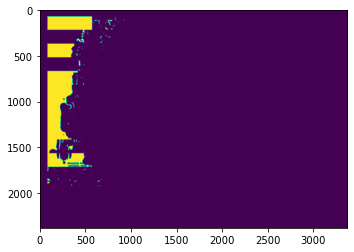

In [192]:
Counter(colours_list)
test = np.zeros_like(binary)
colour_num = 0
cond = (im1[:,:,0] == common_colours[colour_num][0][0])*(im1[:,:,1] == common_colours[colour_num][0][1])*(im1[:,:,2] == common_colours[colour_num][0][2])
test[cond] = 1
plt.imshow(test)

In [137]:
dis_wb = np.sqrt(3*10**2)
common_colours = [
    x for x in colour_counts.most_common() 
    if color.deltaE_cie76((0, 0, 0), x[0]) > dis_wb
    and color.deltaE_cie76((255, 255, 255), x[0]) > dis_wb
]

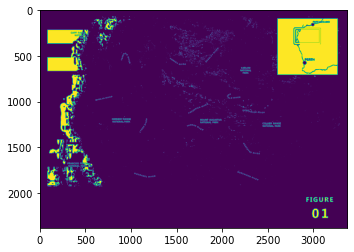

In [178]:
test = np.zeros_like(binary)
for i in range(20):
    cond = (im1[:,:,0] == common_colours[i][0][0])
    cond *= (im1[:,:,1] == common_colours[i][0][1])
    cond *= (im1[:,:,2] == common_colours[i][0][2])
    test[cond] = i*10
plt.imshow(test>0)

In [198]:
colour_counts[(254,255,255)]

374699

In [308]:
from sklearn.cluster import KMeans
from sklearn.utils import shuffle

sample_ratio=0.05
im1_sample = shuffle(
    im1.reshape(im1.shape[0]*im1.shape[1],3)
)[:int(im1.shape[0]*im1.shape[1]*sample_ratio)]
kmeans = KMeans(random_state=0, n_clusters=20).fit(im1_sample)
labels = kmeans.predict(im1.reshape(im1.shape[0]*im1.shape[1],3))

In [309]:
np.around(np.abs(kmeans.cluster_centers_)).astype(int)

array([[254, 255, 254],
       [195, 190, 154],
       [ 46,  45,  31],
       [216, 241, 248],
       [ 88, 138, 179],
       [253,   0,   1],
       [215, 223, 192],
       [106, 108, 107],
       [  0, 255,   0],
       [  1,   2,   1],
       [245, 248, 246],
       [215,  36,  51],
       [196, 217, 160],
       [230, 235, 232],
       [245, 124, 126],
       [146, 154, 139],
       [ 97, 133,  62],
       [209, 217, 220],
       [ 80,  81,  80],
       [176, 183, 181]])

In [310]:
counts = [((labels==i).sum(), i) for i in range(len(kmeans.cluster_centers_))]
sorted(counts)[::-1]

[(5297796, 0),
 (1017848, 3),
 (601006, 10),
 (273199, 13),
 (210883, 1),
 (147040, 12),
 (109375, 17),
 (103593, 6),
 (40592, 15),
 (37436, 7),
 (35445, 19),
 (32992, 9),
 (29677, 5),
 (19786, 2),
 (17761, 18),
 (15607, 16),
 (13567, 11),
 (11034, 14),
 (10634, 4),
 (5439, 8)]

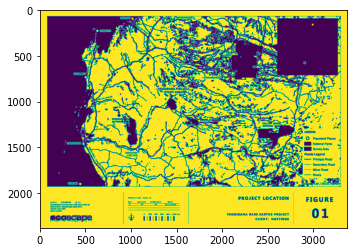

In [315]:
plt.imshow(labels.reshape(im1.shape[:2])==0)

In [166]:
common_colours
colours_kmeans = [x[0] for x in common_colours]
colours_kmeans

[(217, 241, 246),
 (196, 190, 154),
 (210, 239, 255),
 (217, 241, 247),
 (255, 0, 0),
 (217, 241, 245),
 (217, 242, 246),
 (217, 242, 245),
 (216, 241, 246),
 (216, 242, 245),
 (95, 131, 60),
 (216, 241, 245),
 (243, 246, 245),
 (217, 242, 244),
 (217, 242, 247),
 (216, 241, 247),
 (218, 242, 246),
 (82, 133, 176),
 (242, 245, 244),
 (217, 241, 244),
 (216, 242, 246),
 (58, 54, 15),
 (216, 242, 244),
 (255, 126, 126),
 (241, 244, 243),
 (216, 241, 244),
 (78, 78, 78),
 (0, 255, 0),
 (218, 242, 247),
 (240, 243, 242),
 (216, 240, 246),
 (215, 241, 245),
 (217, 240, 246),
 (239, 242, 241),
 (218, 241, 246),
 (211, 30, 44),
 (217, 240, 247),
 (238, 241, 240),
 (215, 241, 246),
 (218, 242, 245),
 (237, 240, 239),
 (216, 240, 245),
 (170, 170, 170),
 (217, 241, 248),
 (209, 239, 255),
 (236, 239, 238),
 (216, 240, 247),
 (215, 242, 245),
 (199, 219, 161),
 (235, 238, 237),
 (217, 240, 245),
 (216, 241, 243),
 (218, 241, 247),
 (234, 237, 236),
 (101, 101, 101),
 (233, 236, 235),
 (153, 153,

In [81]:
from collections import Counter
colour_counts = Counter(colours_list)
len(colour_counts)

107035

In [106]:
color.deltaE_cie76([1,1,1],[1,3,3])

2.8284271247461903

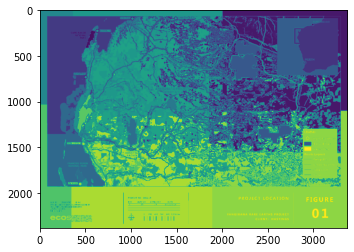

In [97]:
np.amax(labels)
len(np.unique(labels))

plt.imshow(labels)

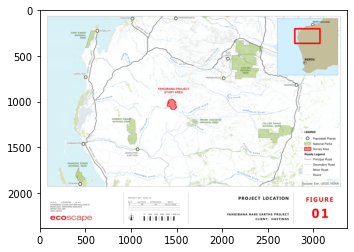

In [68]:
plt.imshow(im1)

In [69]:
3000*1500

4500000

In [12]:
filled = ndi.binary_fill_holes(result==2)
label_objects, nb_labels = ndi.label(filled)
sizes = np.bincount(label_objects.ravel())
mask_sizes = sizes > 500
mask_sizes[0]=0
results1 = mask_sizes[label_objects]
test_image = Image.fromarray(results1)

contours, hierarchy = cv.findContours(gray, cv.RETR_TREE, cv.CHAIN_APPROX_TC89_L1)

NameError: name 'result' is not defined

In [13]:
gray = cv.cvtColor(
    legend, 
    cv.COLOR_BGR2GRAY
)
binary = copy.deepcopy(gray)
binary[binary>0] = 1

In [108]:
list_num = [[1,2], [1,2]]
array_num = np.array(list_num)
np.equal(list_num[0], 2, dtype=int).tolist()

[False, True]

In [21]:
len(np.ones([20,14]))

20

In [29]:
hist = np.equal(np.array([[1,2],[1,2],[1,2]])[0],2).astype(int).tolist()
hist

[0, 1]

In [77]:
from collections import namedtuple
from operator import mul
from functools import reduce # py3k

Info = namedtuple('Info', 'start height')

def max_size(mat, value=0):
    """Find height, width of the largest rectangle containing all `value`'s.
    For each row solve "Largest Rectangle in a Histrogram" problem [1]:
    [1]: http://blog.csdn.net/arbuckle/archive/2006/05/06/710988.aspx
    """
    it = iter(mat)
    hist = [(el==value) for el in next(it, [])]
    max_size = max_rectangle_size(hist, 0)
    row_count = 1
    for row in it:
        hist = [(1+h) if el == value else 0 for h, el in zip(hist, row)]
        max_size = max(max_size, max_rectangle_size(hist, row_count), key=area)
        row_count += 1
    return max_size

def max_rectangle_size(histogram, row_count):
    """Find height, width of the largest rectangle that fits entirely under
    the histogram.
    """
    stack = []
    top = lambda: stack[-1]
    max_size = (0, 0, row_count, 0) # height, width of the largest rectangle
    pos = 0 # current position in the histogram
    for pos, height in enumerate(histogram):
        start = pos # position where rectangle starts
        while True:
            if not stack or height > top().height:
                stack.append(Info(start, height)) # push
            elif stack and height < top().height:
                max_size = max(
                    max_size, 
                    (
                        top().height, 
                        (pos - top().start), 
                        row_count-height,
                        top().start
                    ),
                    key=area
                )
                start, _ = stack.pop()
                continue
            break # height == top().height goes here

    pos += 1
    for start, height in stack:
        max_size = max(
            max_size, 
            (
                height, 
                (pos - start), 
                row_count-height,
                start
            ), 
            key=area
        )

    return max_size

def area(size):
    return reduce(mul, size[0:2])

In [78]:
rows, columns = np.where(binary>0)
obj_range = [np.amin(rows), np.amax(rows), np.amin(columns), np.amax(columns)]

ax = plt.subplot(111)
ax.imshow(binary[obj_range[0]:obj_range[1], obj_range[2]:obj_range[3]])
ax.plot([rec[3],rec[3],rec[3]+rec[1],rec[3]+rec[1],rec[3]], [rec[2],rec[2]-rec[0],rec[2]-rec[0],rec[2],rec[2]] ,'-r')

rec = max_size(binary[obj_range[0]:obj_range[1], obj_range[2]:obj_range[3]],1)
rec

In [103]:
cv.moments(contours[pos_legend_inds[0]])

{'m00': 297309.5,
 'm10': 915454539.6666666,
 'm01': 443698361.8333333,
 'm20': 2822821146543.083,
 'm11': 1364837267540.2915,
 'm02': 679162429163.25,
 'm30': 8716552934110234.0,
 'm21': 4204242616997971.5,
 'm12': 2087458285117532.2,
 'm03': 1063293051145917.0,
 'mu20': 4017797856.5844727,
 'mu11': -1367578194.5007324,
 'mu02': 16996449624.810913,
 'mu30': -22405206124.0,
 'mu21': -53603394070.67676,
 'mu12': 310903216246.97656,
 'mu03': -1004762914864.875,
 'nu20': 0.04545383275601249,
 'nu11': -0.015471577404456432,
 'nu02': 0.1922828888531724,
 'nu30': -0.00046486513729124794,
 'nu21': -0.0011121678151958616,
 'nu12': 0.006450646582096193,
 'nu03': -0.020846907088414992}

In [100]:
@njit
def find_inscribed_rec(binary): # Input a 2-dim binary numpy array
    max_row = np.amax(np.where(binary)[0])
    min_row = np.amin(np.where(binary)[0])
    max_col = np.amax(np.where(binary)[1])
    min_col = np.amin(np.where(binary)[1])
    
    contained=False
    while contained == False
        min_row += 1

In [57]:
hierarchy = hierarchy[0,:,:]
hierarchy

array([[  -1,   -1,    1,   -1],
       [   2,   -1,   -1,    0],
       [   3,    1,   -1,    0],
       ...,
       [8498,   -1,   -1, 8496],
       [8499, 8497,   -1, 8496],
       [  -1, 8498,   -1, 8496]], dtype=int32)

In [64]:
# edges1 = feature.canny(im1[:,:,1]).astype(int)
edges1 = feature.canny(im1[:,:,2], sigma=1)
# plt.imshow(edges1)

# gray = cv.cvtColor(
#     edges1, 
#     cv.COLOR_BGR2GRAY
# )
# contours, hierarchy = cv.findContours(
#     gray, 
#     cv.RETR_TREE, 
#     cv.CHAIN_APPROX_SIMPLE
# )

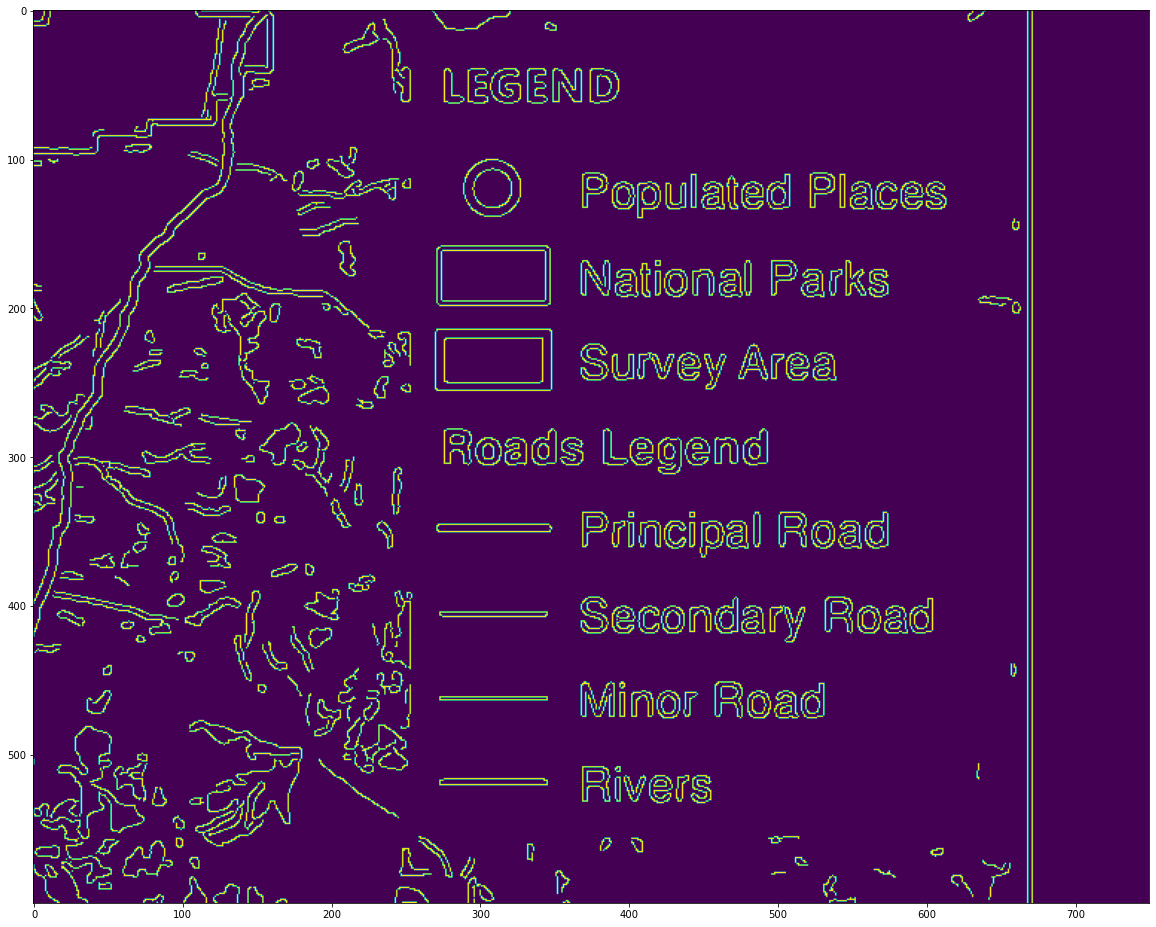

In [65]:
plt.figure(figsize=(20,20))
plt.imshow(edges1[-1100:-500,-750:])

# plt.imshow(skimage.filters.sobel(im1))

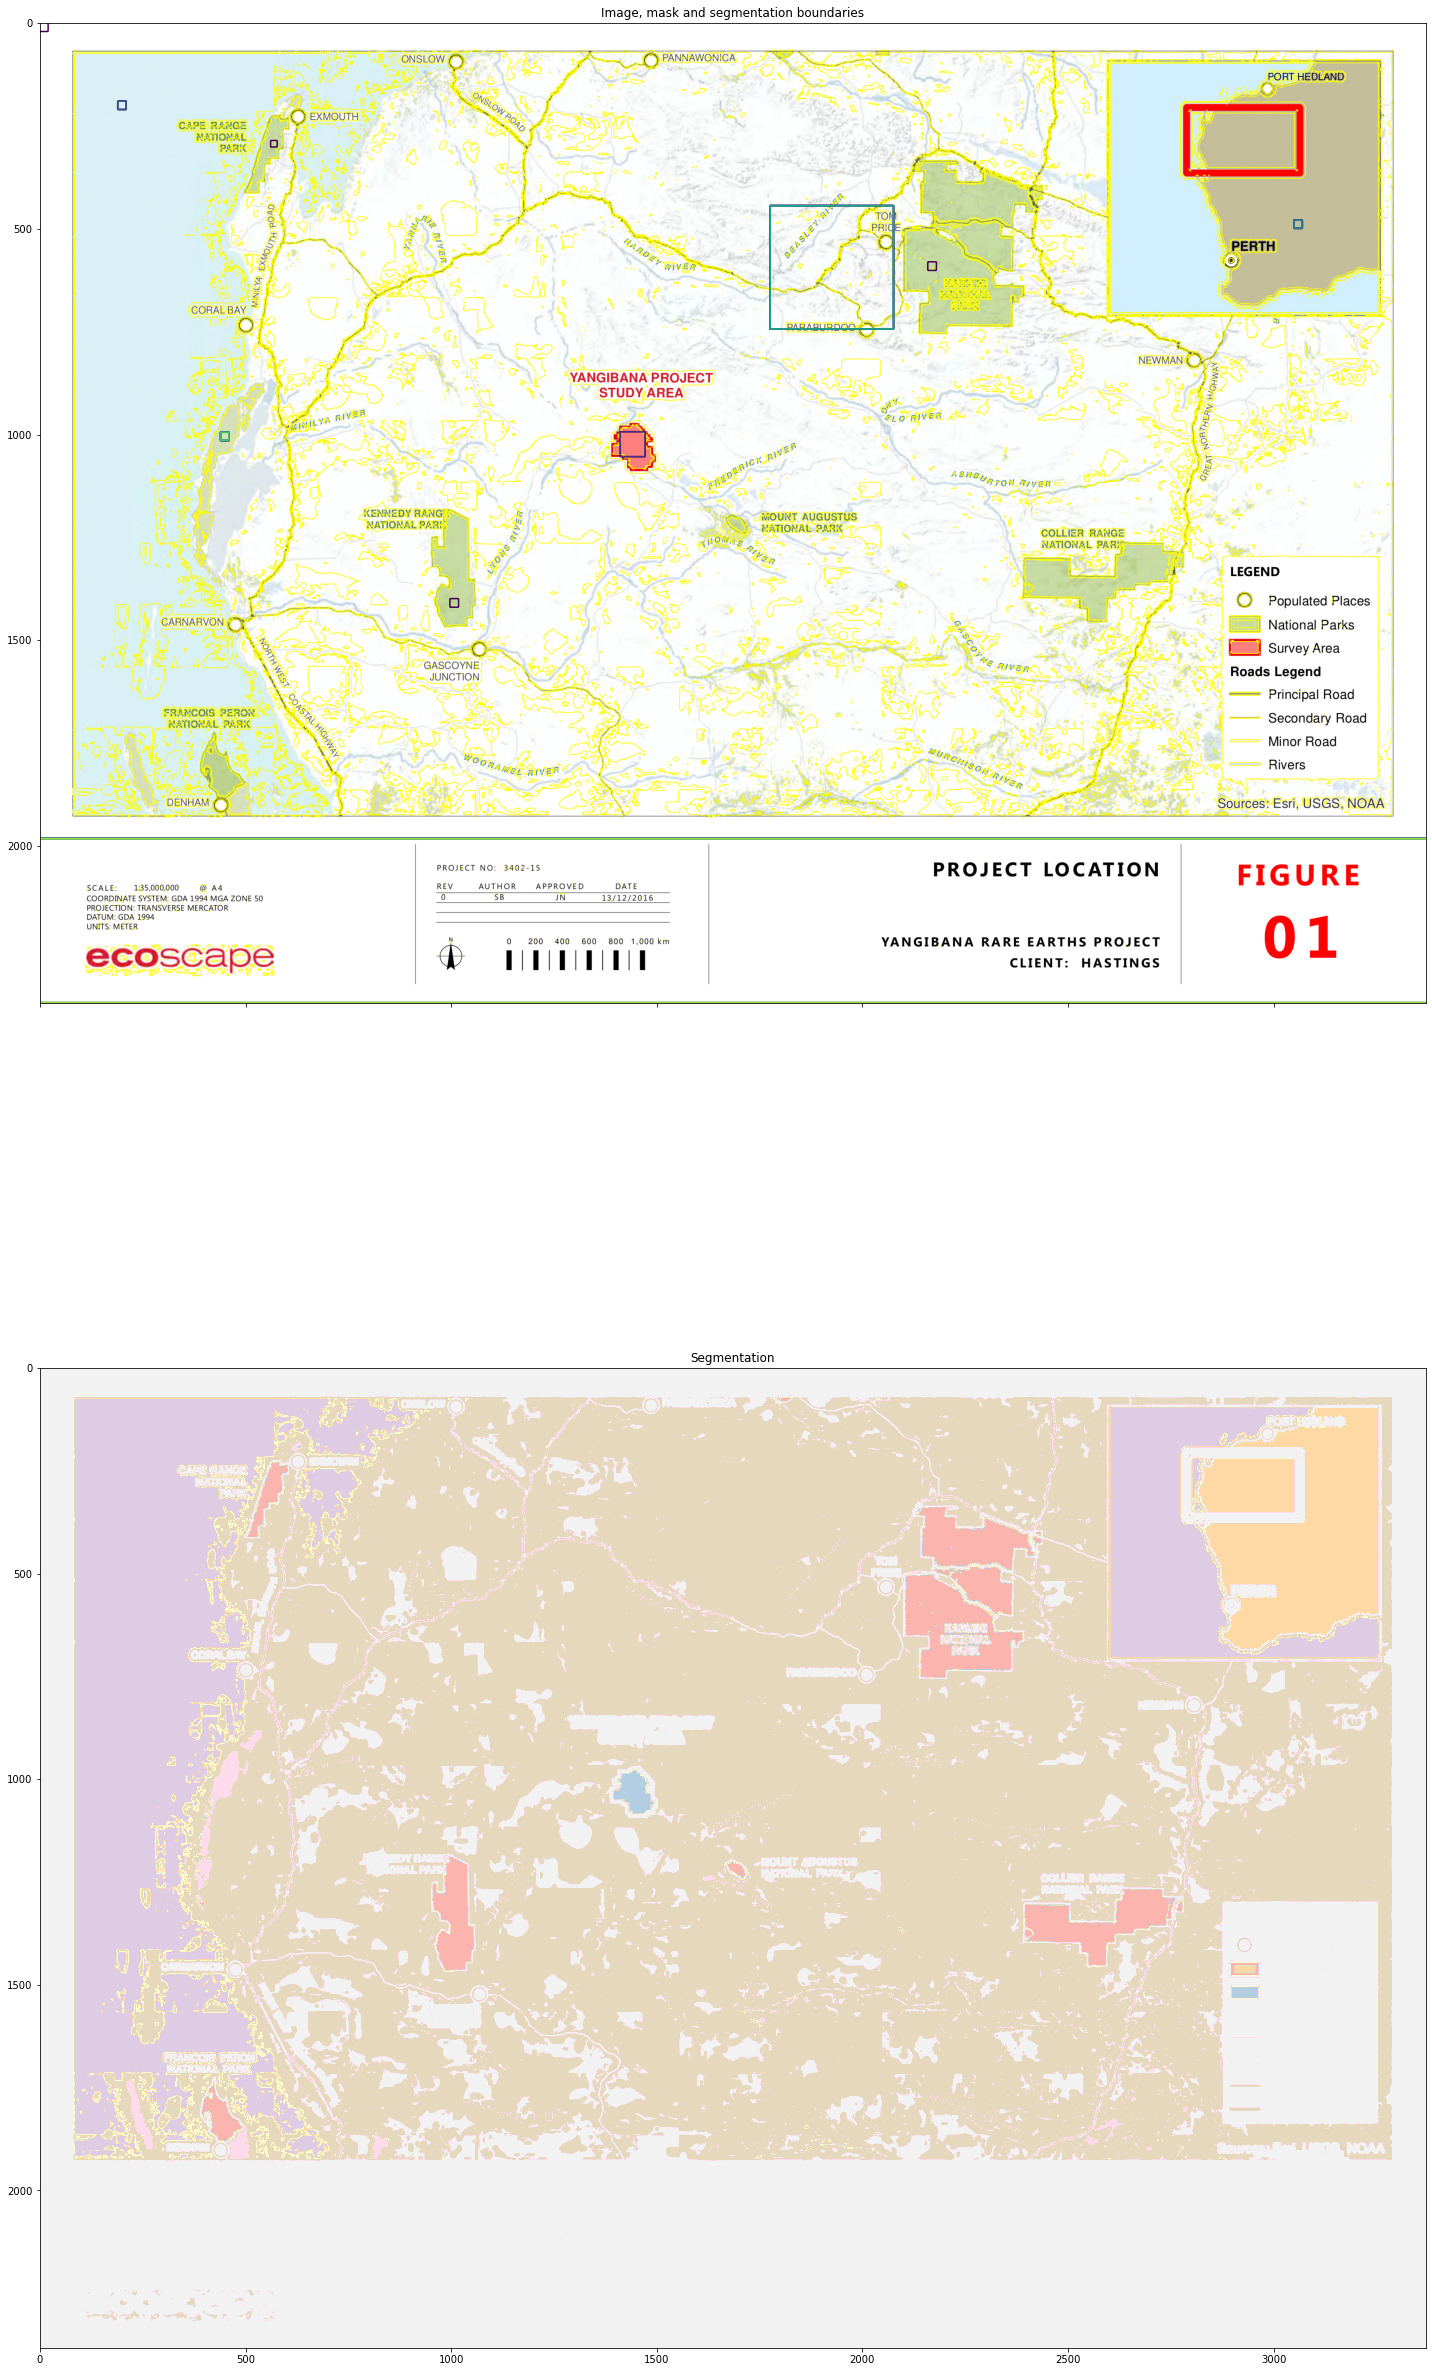

In [8]:
# Build an array of labels for training the segmentation.
# Here we use rectangles but visualization libraries such as plotly
# (and napari?) can be used to draw a mask on the image.
img = im
training_labels = np.zeros(img.shape[:2], dtype=np.uint8)

box_radius = 10

training_labels[box_radius-box_radius:box_radius+box_radius, box_radius-box_radius:box_radius+box_radius] = 1

training_labels[291-5:291+box_radius, 567-5:567+box_radius] = 1
training_labels[1410-box_radius:1410+box_radius,1008-box_radius:1008+box_radius] = 1
training_labels[591-box_radius:591+box_radius, 2170-box_radius:2170+box_radius] = 1
training_labels[1024-3*box_radius:1024+3*box_radius, 1442-3*box_radius:1442+3*box_radius] = 2
training_labels[200-box_radius:200+box_radius, 200-box_radius:200+box_radius] = 3
training_labels[489-box_radius:489+box_radius, 3060-box_radius:3060+box_radius] = 4
training_labels[594-box_radius*15:594+box_radius*15, 1926-box_radius*15:1926+box_radius*15] = 5
training_labels[1005-box_radius:1005+box_radius, 450-box_radius:450+box_radius] = 6
training_labels[-40*box_radius:-1, :] = 7

sigma_min = 1
sigma_max = 2
features_func = partial(feature.multiscale_basic_features,
                        intensity=True, edges=False, texture=True,
                        sigma_min=sigma_min, sigma_max=sigma_max,
                        multichannel=True)
features = features_func(img)
clf = RandomForestClassifier(n_estimators=50, n_jobs=-1,
                             max_depth=10, max_samples=0.05)
clf = future.fit_segmenter(training_labels, features, clf)
result = future.predict_segmenter(features, clf)

fig, ax = plt.subplots(2, 1, sharex=True, sharey=True, figsize=(20, 40))
ax[0].imshow(segmentation.mark_boundaries(img, result, mode='thick'))
ax[0].contour(training_labels)
ax[0].set_title('Image, mask and segmentation boundaries')
ax[1].imshow(result, cmap='Pastel1')
ax[1].set_title('Segmentation')
fig.tight_layout()

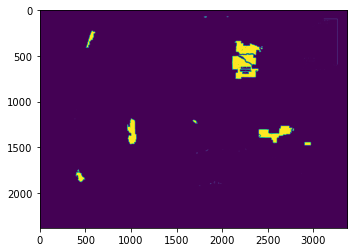

In [104]:
plt.imshow(result==1)

In [76]:
lons = copy.deepcopy(result)
lats = copy.deepcopy(result)

In [80]:
rows = [628, 735, 1901, 746]
cols = [228, 501, 439, 2010]
lats = [-21.932907, -23.142694, -25.927649, -23.200824]
lons = [114.124272, 113.770688, 113.536138, 117.671343]

In [94]:
result.shape

(2383, 3370)

In [ ]:
result==1

In [99]:
lats_guess = f_lat(np.array(list(range(result.shape[0]))))*-1
lons_guess = f_lon(np.array(list(range(result.shape[1]))))

In [100]:
lons_guess

array([113.28269061, 113.28380222, 113.28491383, ..., 120.86112123,
       120.86347184, 120.86582245])

In [351]:
filled = ndi.binary_fill_holes(result==2)
label_objects, nb_labels = ndi.label(filled)
sizes = np.bincount(label_objects.ravel())
mask_sizes = sizes > 500
mask_sizes[0]=0
results1 = mask_sizes[label_objects]
test_image = Image.fromarray(results1)
test_image.save("test.png")

In [352]:
test_image = cv.imread('test.png')
gray = cv.cvtColor(test_image, cv.COLOR_BGR2GRAY)

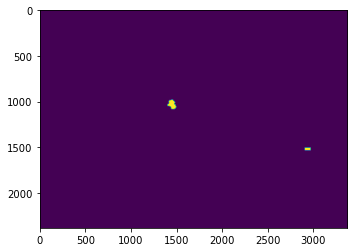

In [353]:
plt.imshow(gray)

In [286]:
test = np.zeros_like(result)
test[result==2]=1
test_image = Image.fromarray(test)
test_image.save("test.png")

In [354]:
contours, hierarchy = cv.findContours(gray, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_TC89_L1)

In [355]:
len(contours)

2

In [356]:
from pyproj import Proj, transform

In [357]:
p = Proj(proj='tmerc', crs='GDA94', zone=50, ellps='GRS80', lon_0=117, lat_0=0, units='m', k_0='0.9996')

In [358]:
y = np.array(list(range(result.shape[0])), dtype=float)
x = np.array(list(range(result.shape[1])), dtype=float)

In [359]:
result.shape

(2383, 3370)

In [360]:
x = x*261.30489
y = y*261.30489

In [361]:
x = x - x[1486]
y = -y + y[91]

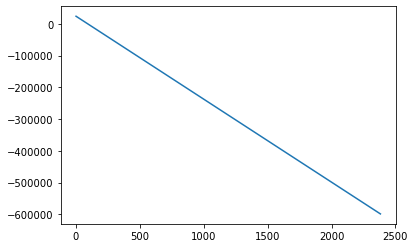

In [362]:
plt.plot(y)

In [363]:
g = Geod(ellps='GRS80')

In [364]:
az12,az21,dist1 = g.inv(116.325261,-21.643626,116.325261,0)
az12,az21,dist2 = g.inv(116.325261,-21.643626,117,-21.643626)
dist2

69847.68451011913

In [365]:
az12,az21,dist1 = g.inv(113.658431,-24.882144,115.200064,-25.050686)
dist1

156784.89897473305

In [366]:
x = x - 69847.68451011913
y = y - 2394339.940538073

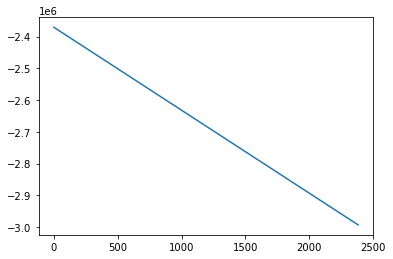

In [367]:
plt.plot(y)

In [368]:
y[746]

-2565494.643488073

In [369]:
XX, YY = np.meshgrid(x,y)

In [370]:
LON, LAT = p(XX, YY, inverse=True)

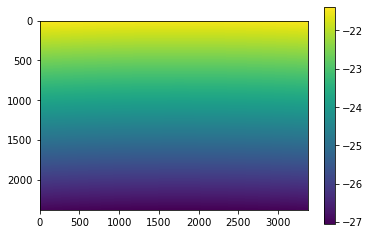

In [371]:
plt.imshow(LAT)
plt.colorbar()

In [372]:
print(LON[contours[0][0][0][0],contours[0][0][0][1]])
print(LAT[contours[0][0][0][0],contours[0][0][0][1]])

IndexError: index 2897 is out of bounds for axis 0 with size 2383

In [373]:
contours[1]

array([[[1440,  978]],

       [[1437,  981]],

       [[1437,  979]],

       [[1437,  981]],

       [[1434,  983]],

       [[1434,  985]],

       [[1416,  985]],

       [[1414,  986]],

       [[1414,  989]],

       [[1415,  993]],

       [[1413,  995]],

       [[1412,  986]],

       [[1412,  995]],

       [[1410,  997]],

       [[1408,  997]],

       [[1410,  997]],

       [[1413,  999]],

       [[1407, 1000]],

       [[1408, 1004]],

       [[1409, 1006]],

       [[1411, 1007]],

       [[1405, 1008]],

       [[1410, 1008]],

       [[1412, 1010]],

       [[1412, 1012]],

       [[1413, 1010]],

       [[1414, 1014]],

       [[1412, 1014]],

       [[1410, 1017]],

       [[1408, 1017]],

       [[1410, 1017]],

       [[1413, 1017]],

       [[1413, 1020]],

       [[1407, 1021]],

       [[1408, 1026]],

       [[1406, 1028]],

       [[1395, 1029]],

       [[1396, 1048]],

       [[1418, 1049]],

       [[1416, 1051]],

       [[1419, 1052]],

       [[1420, 1

In [374]:
LAT[91,1486]

-21.650907489170546

In [375]:
poly_coords = [
    [
        str(LON[contours[i][j][0][1],contours[i][j][0][0]]) + ',' 
        + str(LAT[contours[i][j][0][1],contours[i][j][0][0]]) + ',1.'
        for j in range(len(contours[i]))
    ]
    for i in range(len(contours))
]

In [376]:
poly_num=1
for i in range(len(poly_coords[poly_num])):
    print(poly_coords[poly_num][i])

116.1966943250589,-23.74401839132433,1.
116.1889591149908,-23.751058290891393,1.
116.18898834833337,-23.746338249807856,1.
116.1889591149908,-23.751058290891393,1.
116.18123783525786,-23.755737760706463,1.
116.18120830943906,-23.760457786926306,1.
116.13505478010545,-23.760206281425067,1.
116.12991095967745,-23.762537466289537,1.
116.12986387657837,-23.769617404367665,1.
116.13236550464455,-23.779071743665256,1.
116.12720513091799,-23.783762782902937,1.
116.12478274523446,-23.7625084969337,1.
116.12464060843014,-23.783748262420165,1.
116.11947977598224,-23.7884390270388,1.
116.11435056024636,-23.788409681411093,1.
116.11947977598224,-23.7884390270388,1.
116.12714209095262,-23.793202666127677,1.
116.11173783289242,-23.795474824542918,1.
116.11423856929882,-23.80492940227889,1.
116.11677157694126,-23.809664024761727,1.
116.1218857584604,-23.81205327509646,1.
116.10647919209677,-23.814324834494982,1.
116.11930476376787,-23.814398608202026,1.
116.12440334517213,-23.819147739944174,1.
116.1